In [1]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
locations = pd.read_csv('./dat/locations.csv',dtype={'location':str})

In [4]:
model = "MOBS_NEU-GLEAM_COVID"
rd=12
predictions = pd.read_parquet(f'./dat/{model}_rd{rd}.pq')

loclist = list(predictions.location.unique())
loclist.remove('US')

In [5]:
rd = 12
start_week = Week(2022,2)
end_week = Week(2022,13)
#max_date = datetime.datetime(2022, 3, 15)
max_date = None
models = ["Ensemble","Ensemble_LOP","Ensemble_LOP_untrimmed","JHU_IDD-CovidSP","MOBS_NEU-GLEAM_COVID","NCSU-COVSIM","NotreDame-FRED","UNCC-hierbin","USC-SIkJalpha",
           "UTA-ImmunoSEIRS","UVA-EpiHiper","UVA-adaptive"]

In [10]:
median_ensembles = dict()
extreme_ensembles = dict()

df = pd.DataFrame(columns=['target_end_date','value','population', 'Model', 'Location'])

for l in loclist:
    median_ensembles[l] = {}
    extreme_ensembles[l] = {}
    
    target = 'death'
    #target = 'hosp'
    #target = 'case'
    incidence = True
    target_location = l
    
    
    if target == 'hosp':
        target_obs = 'hospitalization'
    else:
        target_obs = target
    observations = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
    observations['date'] = pd.to_datetime(observations['date'])

    #filter start - end week
    observations = observations[(observations['date'] >= pd.to_datetime(start_week.startdate())) & 
                            (observations['date'] <= pd.to_datetime(end_week.enddate()))]


    
    #filter location
    observations = observations[observations['location'] == target_location]

    #aggregate to weekly
    observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

    if max_date:
        observations = observations[observations['date'] <= max_date].copy()

    #transform to Observation object
    observations = Observations(observations)
    

    
    
    locations = pd.read_csv('./dat/locations.csv',dtype={'location':str})
    location_mapping = dict()
    for loc in locations['location']:
        location_mapping[loc] = locations[locations['location'] == loc]['abbreviation'].unique()[0]
    
    
    target_prediction_list = [f"{i} wk ahead {'inc' if incidence else 'cum'} {target}" for i in range(1,len(observations)+1)]
    
    for model in models:    
        try:
            predictions = pd.read_parquet(f'./dat/{model}_rd{rd}.pq')
            predictions['target_end_date'] = pd.to_datetime(predictions['target_end_date'])
            predictions = predictions[predictions.location != 'US']
            predictions = predictions.astype({'location':'int'})
            
            
            locations = locations[locations.location != 'US']
            locations = locations.astype({'location':'int'})
            
            predictions = predictions.merge(locations, how='inner', on='location')
            
            target_locations = int(target_location)
            
            pred = predictions[predictions['location'] == int(target_location)].copy()
        
            #filter target
            pred = pred[(pred['target'].isin(target_prediction_list))]
            
            #filter max date
            if max_date:
                pred = pred[pred['target_end_date'] <= max_date]

            if len(pred) == 0:
                raise RuntimeError(f"There are no predictions for model {model} at location {target_location}")

            scenarios = list(pred['scenario_id'].drop_duplicates())
            predictions_list = [Predictions(pred[pred['scenario_id'] == scenario], t_col='target_end_date') for scenario in scenarios]
            med_ensemble_predictions = median_ensemble(predictions_list)
            ex_ensemble_predictions = extreme_ensemble(predictions_list)
            median_ensembles[l][model] = med_ensemble_predictions
            extreme_ensembles[l][model] = ex_ensemble_predictions
            
            predictions_list += [med_ensemble_predictions, ex_ensemble_predictions]
            
            
            # want to use medians as 'point' forecast instead of the point forecast since ensemble models do not have
            # a reported 'point' forecast
            
            medens_ptforecast = med_ensemble_predictions[med_ensemble_predictions['quantile'] == 0.5].reset_index()
            
            medens_ptforecast = medens_ptforecast[['target_end_date', 'value','population']]
            
            medens_ptforecast['Model'] = model
            
            locname = list(pred.location_name.unique())[0]
            medens_ptforecast['Location'] = locname
            
            
            df = pd.concat([df, medens_ptforecast])
           
            
  
        except Exception as e:
            print(e)    
    


There are no predictions for model NCSU-COVSIM at location 01
There are no predictions for model NotreDame-FRED at location 01
There are no predictions for model UTA-ImmunoSEIRS at location 01
There are no predictions for model NCSU-COVSIM at location 02
There are no predictions for model NotreDame-FRED at location 02
There are no predictions for model UTA-ImmunoSEIRS at location 02
There are no predictions for model NCSU-COVSIM at location 04
There are no predictions for model NotreDame-FRED at location 04
There are no predictions for model UTA-ImmunoSEIRS at location 04
There are no predictions for model NCSU-COVSIM at location 05
There are no predictions for model NotreDame-FRED at location 05
There are no predictions for model UTA-ImmunoSEIRS at location 05
There are no predictions for model NCSU-COVSIM at location 06
There are no predictions for model NotreDame-FRED at location 06
There are no predictions for model NCSU-COVSIM at location 08
There are no predictions for model Notr

There are no predictions for model UTA-ImmunoSEIRS at location 49
There are no predictions for model NCSU-COVSIM at location 50
There are no predictions for model NotreDame-FRED at location 50
There are no predictions for model UTA-ImmunoSEIRS at location 50
There are no predictions for model NCSU-COVSIM at location 51
There are no predictions for model NotreDame-FRED at location 51
There are no predictions for model UTA-ImmunoSEIRS at location 51
There are no predictions for model NCSU-COVSIM at location 53
There are no predictions for model NotreDame-FRED at location 53
There are no predictions for model UTA-ImmunoSEIRS at location 53
There are no predictions for model NCSU-COVSIM at location 54
There are no predictions for model NotreDame-FRED at location 54
There are no predictions for model UTA-ImmunoSEIRS at location 54
There are no predictions for model NCSU-COVSIM at location 55
There are no predictions for model NotreDame-FRED at location 55
There are no predictions for model 

In [11]:
df_point_death = df

In [12]:
df_point_hosp.to_pickle('df_point_hosp.pkl') 
df_point_death.to_pickle('df_point_death.pkl')
df_point_case.to_pickle('df_point_case.pkl')

In [26]:
target = 'case'

obsdf = pd.DataFrame()


for l in loclist:    
    target_location = l
    
    if target == 'hosp':
        target_obs = 'hospitalization'
    else:
        target_obs = target
    observations = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
    observations['date'] = pd.to_datetime(observations['date'])

    #filter start - end week
    observations = observations[(observations['date'] >= pd.to_datetime(start_week.startdate())) & 
                            (observations['date'] <= pd.to_datetime(end_week.enddate()))]


    
    #filter location
    observations = observations[observations['location'] == target_location]

    #aggregate to weekly
    observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

    if max_date:
        observations = observations[observations['date'] <= max_date].copy()

    #transform to Observation object
    observations = Observations(observations)
    

    obsdf = pd.concat([obsdf, observations])

In [27]:
obsdf = obsdf.reset_index()

obsdf_case = obsdf.copy()

In [28]:
#obsdf_death = obsdf_death.astype({'location':'int'})
#obsdf_death = obsdf_death.merge(locations, how='inner', on='location')
#obsdf_death = obsdf_death.drop(['index'], axis=1)

#obsdf_hosp = obsdf_hosp.astype({'location':'int'})
#obsdf_hosp = obsdf_hosp.merge(locations, how='inner', on='location')
#obsdf_hosp = obsdf_hosp.drop(['index'], axis=1)

obsdf_case = obsdf_case.astype({'location':'int'})
obsdf_case = obsdf_case.merge(locations, how='inner', on='location')
obsdf_case = obsdf_case.drop(['index'], axis=1)


In [138]:
obsdf_case

,location,date,value,abbreviation,location_name,population
0,1,2022-01-15,38442,AL,Alabama,4903185
1,1,2022-01-22,132765,AL,Alabama,4903185
2,1,2022-01-29,68921,AL,Alabama,4903185
3,1,2022-02-05,36112,AL,Alabama,4903185
4,1,2022-02-12,19598,AL,Alabama,4903185
...,...,...,...,...,...,...
454,56,2022-02-12,2739,WY,Wyoming,578759
455,56,2022-02-19,1501,WY,Wyoming,578759
456,56,2022-02-26,827,WY,Wyoming,578759
457,56,2022-03-05,517,WY,Wyoming,578759


In [29]:
dfpt = df_point_case
obs = obsdf_case

models = list(dfpt.Model.unique())
locs = list(dfpt.Location.unique())

mapedf = pd.DataFrame(columns=['Model', 'Location','Population', 'MAPE'])

for model in models:
    for l in locs:
        a = dfpt[(dfpt.Model ==model)& (dfpt.Location ==l)]
        b = obs[obs.location_name ==l]   # i think observations only run until 10/31/22

        n = b.shape[0]

        mapesum = 0
        realvals = list(b.value)
        predvals = list(a.value)
        
        if len(predvals) == 0:
            continue
        
        for i in range(n):
            if realvals[i] == 0:
                n = n - 1
                continue
            
            err = abs((realvals[i]-predvals[i])/realvals[i]) # error if real vals is zero, what to do
    
            mapesum += err
    
        mape = 1/n * mapesum

    
        data = {'Model': model,'Location': l,'Population': a.population.unique()[0], 'MAPE':mape}
  
        # Create DataFrame
        newdf = pd.DataFrame(data, index=[1])
    
        mapedf = pd.concat([mapedf, newdf])
        
mapedf = mapedf.reset_index()
mapedf = mapedf.drop(['index'], axis=1)

In [30]:
mapedf_case = mapedf

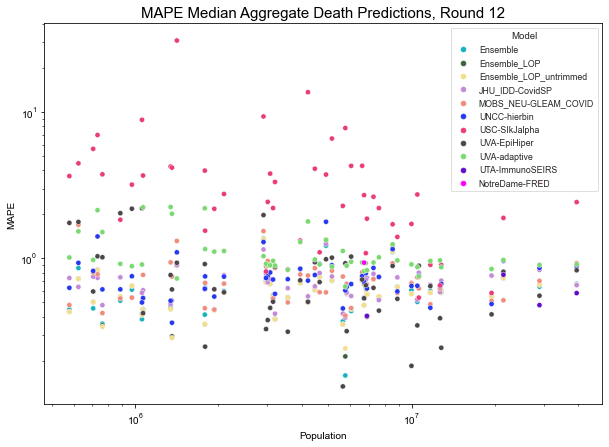

In [20]:
fig, ax = plt.subplots(figsize=(10,7))
flatui = ['#17B1BF', '#3E603B', '#F3DE8A', '#C38AD8', '#F18C7D', '#2539F0', '#E93C78', '#4C454A', '#7ADA71', '#5F0EC9','magenta']
sns.set_palette(flatui)

sns.set_style("white")
sns.axes_style("white")
sns.set_context("paper", rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15})
sns.set_palette(flatui)




sns.scatterplot(ax = ax, data = mapedf_death,x=mapedf_death['Population'],
                y=mapedf_death['MAPE']
                , hue='Model' , s=27).set(title='MAPE Median Aggregate Death Predictions, Round 12')
ax.set( ylabel='MAPE')
plt.xscale('log')
plt.yscale('log')
#plt.savefig('mapepop_death.pdf')
plt.show()

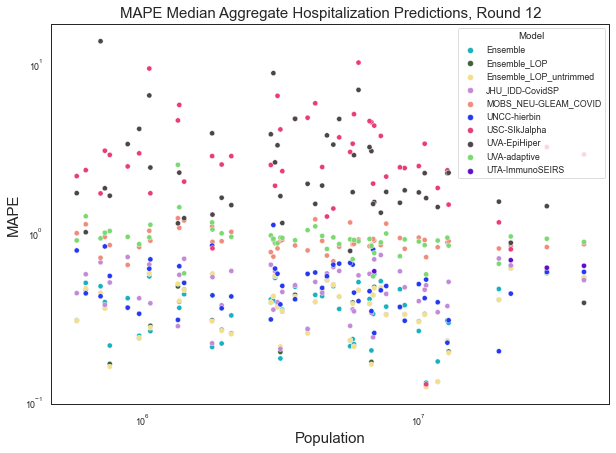

In [31]:
fig, ax = plt.subplots(figsize=(10,7))
flatui = ['#17B1BF', '#3E603B', '#F3DE8A', '#C38AD8', '#F18C7D', '#2539F0', '#E93C78', '#4C454A', '#7ADA71', '#5F0EC9','magenta']
sns.set_palette(flatui)

sns.set_style("white")
sns.axes_style("white")
sns.set_context("paper", rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15})
sns.set_palette(flatui)




sns.scatterplot(ax = ax, data = mapedf_hosp,x=mapedf_hosp['Population'],
                y=mapedf_hosp['MAPE']
                , hue='Model' , s=27).set(title='MAPE Median Aggregate Hospitalization Predictions, Round 12')
ax.set( ylabel='MAPE')
plt.xscale('log')
plt.yscale('log')
#plt.savefig('mapepop_hosp.pdf')
plt.show()

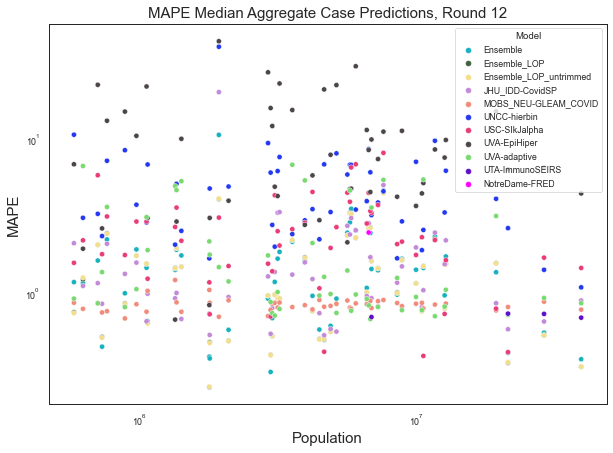

In [32]:
fig, ax = plt.subplots(figsize=(10,7))
flatui = ['#17B1BF', '#3E603B', '#F3DE8A', '#C38AD8', '#F18C7D', '#2539F0', '#E93C78', '#4C454A', '#7ADA71', '#5F0EC9','magenta']
sns.set_palette(flatui)

sns.set_style("white")
sns.axes_style("white")
sns.set_context("paper", rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15})
sns.set_palette(flatui)




sns.scatterplot(ax = ax, data = mapedf_case,x=mapedf_case['Population'],
                y=mapedf_case['MAPE']
                , hue='Model' , s=27).set(title='MAPE Median Aggregate Case Predictions, Round 12')
ax.set( ylabel='MAPE')
plt.xscale('log')
plt.yscale('log')
#plt.savefig('mapepop_case.pdf')
plt.show()

In [33]:

mapedf_hosp.to_pickle('mapedf_hosp.pkl') 
mapedf_death.to_pickle('mapedf_death.pkl')
mapedf_case.to_pickle('mapedf_case.pkl')